# low dose ct 이미지 데이터로 test 성능 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from PIL import Image

In [ ]:
file_path = '/content/drive/MyDrive/DSCOVER/2학기 메인프로젝트/low_dose_ct.zip'

In [ ]:
extract_dir = "dataset"
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print('zip file extracted')

zip file extracted


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transformations
# use mean, std of imagenet dataset to normalize( we will use model that is pretrained with imagenet dataset)
transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


In [ ]:
# Loading dataset and labeling
data = datasets.ImageFolder(root='/content/dataset', transform=transform)
dataloader = DataLoader(data, batch_size=16, shuffle=False)

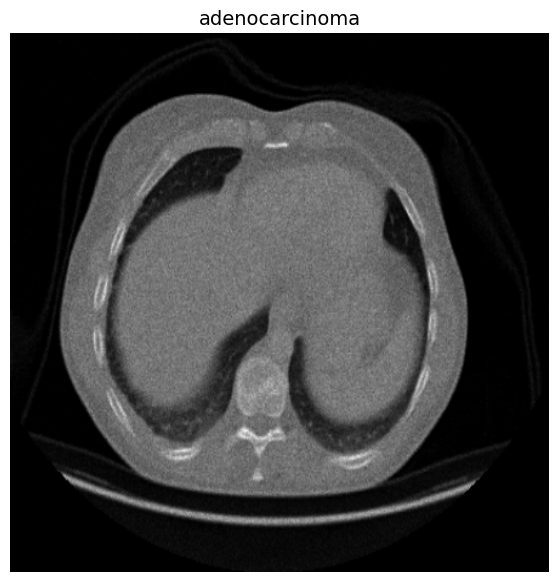

In [ ]:
# Display an example image
def show_random_image(dataset, class_names, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    random_idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[random_idx]

    img_permute = img.permute(1, 2, 0)
    img = img_permute.numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(12, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.title(class_names[label], fontsize=14)
    plt.show()

# Show a random image from training set
show_random_image(data, data.classes, random_state=42)

In [ ]:
# Test the model with low dose ct data set
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    print()
    print(f"Test Accuracy: {accuracy:.4f}")

# Load the best model weights
def load_and_test_model(model_path, dataloader):
    model = models.densenet121(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(data.classes))
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)

    print("Testing with the best saved model...")
    test_model(model, dataloader)

In [ ]:
best_model_path = '/content/drive/MyDrive/DSCOVER/2학기 메인프로젝트/best_lung_cancer_densenet121.pth'

In [ ]:
# Evaluate on the test set using the best model
load_and_test_model(best_model_path, dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-9-616b4f40ee14>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Testing with the best saved model...


Testing: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Test Accuracy: 0.7905


In [ ]:
# Cycle GAN으로 노이즈 제거한 ldct 불러오기
cycle_file_path = '/content/drive/MyDrive/DSCOVER/2학기 메인프로젝트/restored_ldct.zip'

In [ ]:
extract_dir_2 = "cycle_dataset"
with zipfile.ZipFile(cycle_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_2)
print('zip file extracted')

zip file extracted


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transformations
# use mean, std of imagenet dataset to normalize( we will use model that is pretrained with imagenet dataset)
transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


In [ ]:
# Loading dataset and labeling
data_cycle = datasets.ImageFolder(root='/content/cycle_dataset', transform=transform)
dataloader_cycle = DataLoader(data_cycle, batch_size=16, shuffle=False)

FileNotFoundError: Couldn't find any class folder in /content/cycle_dataset.